# Music Classification
We will build a classifier that guesses whether a song is Hip-Hop or Country, using only the numbers of times words appear in the song. We will use <b>k-nearest-neighbors classifier</b> and test the classifier on our data.

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Predicting whether a user will like a song

First, we will try to understand what features distinguish a song that we like from the one that we dislike. Let's load the data and explore it.

In [2]:
liked = pd.read_excel('LIKES.xlsx')
disliked = pd.read_excel('DISLIKES.xlsx')

Using **dropna()** function, we drop the rows from the tables that have missing values.

In [3]:
liked = liked.dropna()
disliked = disliked.dropna()

Here we reset the index so that the dataframes are nicer to work with. We also rename some of the columns.

In [4]:
liked = liked.reset_index(drop=True).rename(columns={"POP.": "POPULARITY"})
disliked = disliked.reset_index(drop=True).rename(columns={"POP.": "POPULARITY"})

Look at the RELEASE column. It contains strings that we can convert to a "YEAR" column which can be useful to us.

In [5]:
liked['YEAR'] = liked['RELEASE'].astype(str).str[0:4]
liked['YEAR'] = liked['YEAR'].convert_objects(convert_numeric=True)

disliked['YEAR'] = disliked['RELEASE'].astype(str).str[0:4]
disliked['YEAR'] = disliked['YEAR'].convert_objects(convert_numeric=True)

In [6]:
liked.head()

,TITLE,ARTIST,RELEASE,BPM,ENERGY,DANCE,LOUD,VALENCE,LENGTH,ACOUSTIC,POPULARITY,YEAR
0,Where Is My Mind?,Pixies,2004-05-03 00:00:00,81.0,44.0,51.0,-14.0,24.0,03:49:00,1.0,35.0,2004
1,Give Me Nurture,rei brown,2016-11-18 00:00:00,97.0,34.0,65.0,-5.0,7.0,01:29:00,88.0,33.0,2016
2,Lullaby,Atlas Bound,2016-05-13 00:00:00,73.0,38.0,73.0,-9.0,17.0,03:40:00,38.0,56.0,2016
3,Warm On A Cold Night,HONNE,2016-07-13 00:00:00,83.0,61.0,34.0,-6.0,39.0,04:22:00,19.0,63.0,2016
4,Release You,Tom Misch,2014-12-08 00:00:00,120.0,36.0,54.0,-13.0,20.0,03:53:00,33.0,53.0,2014


In [7]:
disliked.head()

,TITLE,ARTIST,RELEASE,BPM,ENERGY,DANCE,LOUD,VALENCE,LENGTH,ACOUSTIC,POPULARITY,YEAR
0,With You I Am,Cody Johnson,2016-08-05 00:00:00,75.0,67.0,56.0,-6.0,40.0,03:41:00,40.0,65.0,2016
1,Somewhere Down in Texas,Jason Boland,2001,72.0,49.0,48.0,-11.0,50.0,05:52:00,14.0,5.0,2001
2,Rescue,Hunter Hayes,2017-06-29 00:00:00,90.0,79.0,52.0,-3.0,30.0,03:37:00,29.0,74.0,2017
3,Five More Minutes,Scotty McCreery,2017-05-05 00:00:00,156.0,65.0,52.0,-6.0,31.0,03:59:00,33.0,72.0,2017
4,Singles You Up,Jordan Davis,2017-05-26 00:00:00,200.0,90.0,49.0,-4.0,59.0,03:03:00,4.0,76.0,2017


Using the code above as an example and the "LENGTH" column, we create a column "MINUTES" and a column "SECONDS".

In [8]:
liked["MINUTES"] = liked["LENGTH"].astype(str).str[0:2]
liked["MINUTES"] = liked["MINUTES"].convert_objects(convert_numeric=True)

disliked["MINUTES"] = disliked["LENGTH"].astype(str).str[0:2]
disliked["MINUTES"] = disliked["MINUTES"].convert_objects(convert_numeric=True)

liked["SECONDS"] = liked["LENGTH"].astype(str).str[3:5]
liked["SECONDS"] = liked["SECONDS"].convert_objects(convert_numeric=True)

disliked["SECONDS"] = disliked["LENGTH"].astype(str).str[3:5]
disliked["SECONDS"] = disliked["SECONDS"].convert_objects(convert_numeric=True)

In [9]:
liked.head()

,TITLE,ARTIST,RELEASE,BPM,ENERGY,DANCE,LOUD,VALENCE,LENGTH,ACOUSTIC,POPULARITY,YEAR,MINUTES,SECONDS
0,Where Is My Mind?,Pixies,2004-05-03 00:00:00,81.0,44.0,51.0,-14.0,24.0,03:49:00,1.0,35.0,2004,3,49
1,Give Me Nurture,rei brown,2016-11-18 00:00:00,97.0,34.0,65.0,-5.0,7.0,01:29:00,88.0,33.0,2016,1,29
2,Lullaby,Atlas Bound,2016-05-13 00:00:00,73.0,38.0,73.0,-9.0,17.0,03:40:00,38.0,56.0,2016,3,40
3,Warm On A Cold Night,HONNE,2016-07-13 00:00:00,83.0,61.0,34.0,-6.0,39.0,04:22:00,19.0,63.0,2016,4,22
4,Release You,Tom Misch,2014-12-08 00:00:00,120.0,36.0,54.0,-13.0,20.0,03:53:00,33.0,53.0,2014,3,53


In [10]:
disliked.head()

,TITLE,ARTIST,RELEASE,BPM,ENERGY,DANCE,LOUD,VALENCE,LENGTH,ACOUSTIC,POPULARITY,YEAR,MINUTES,SECONDS
0,With You I Am,Cody Johnson,2016-08-05 00:00:00,75.0,67.0,56.0,-6.0,40.0,03:41:00,40.0,65.0,2016,3,41
1,Somewhere Down in Texas,Jason Boland,2001,72.0,49.0,48.0,-11.0,50.0,05:52:00,14.0,5.0,2001,5,52
2,Rescue,Hunter Hayes,2017-06-29 00:00:00,90.0,79.0,52.0,-3.0,30.0,03:37:00,29.0,74.0,2017,3,37
3,Five More Minutes,Scotty McCreery,2017-05-05 00:00:00,156.0,65.0,52.0,-6.0,31.0,03:59:00,33.0,72.0,2017,3,59
4,Singles You Up,Jordan Davis,2017-05-26 00:00:00,200.0,90.0,49.0,-4.0,59.0,03:03:00,4.0,76.0,2017,3,3


We create a column called "DURATION" from columns MINUTES AND SECONDS. Finally, we drop LENGTH, MINUTES, SECONDS and RELEASE columns.

In [11]:
liked["DURATION"]=liked["MINUTES"]*60+liked["SECONDS"]
disliked["DURATION"]=disliked["MINUTES"]*60+disliked["SECONDS"]

liked=liked.drop(["LENGTH","MINUTES","SECONDS","RELEASE"], axis=1)
disliked=disliked.drop(["LENGTH","MINUTES","SECONDS","RELEASE"], axis=1)

In [12]:
liked.head()

,TITLE,ARTIST,BPM,ENERGY,DANCE,LOUD,VALENCE,ACOUSTIC,POPULARITY,YEAR,DURATION
0,Where Is My Mind?,Pixies,81.0,44.0,51.0,-14.0,24.0,1.0,35.0,2004,229
1,Give Me Nurture,rei brown,97.0,34.0,65.0,-5.0,7.0,88.0,33.0,2016,89
2,Lullaby,Atlas Bound,73.0,38.0,73.0,-9.0,17.0,38.0,56.0,2016,220
3,Warm On A Cold Night,HONNE,83.0,61.0,34.0,-6.0,39.0,19.0,63.0,2016,262
4,Release You,Tom Misch,120.0,36.0,54.0,-13.0,20.0,33.0,53.0,2014,233


In [13]:
disliked.head()

,TITLE,ARTIST,BPM,ENERGY,DANCE,LOUD,VALENCE,ACOUSTIC,POPULARITY,YEAR,DURATION
0,With You I Am,Cody Johnson,75.0,67.0,56.0,-6.0,40.0,40.0,65.0,2016,221
1,Somewhere Down in Texas,Jason Boland,72.0,49.0,48.0,-11.0,50.0,14.0,5.0,2001,352
2,Rescue,Hunter Hayes,90.0,79.0,52.0,-3.0,30.0,29.0,74.0,2017,217
3,Five More Minutes,Scotty McCreery,156.0,65.0,52.0,-6.0,31.0,33.0,72.0,2017,239
4,Singles You Up,Jordan Davis,200.0,90.0,49.0,-4.0,59.0,4.0,76.0,2017,183


This is an overlayed histogram "ENERGY of liked and ENERGY of disliked songs". We use an alpha = 0.5 to make the histograms transperent.

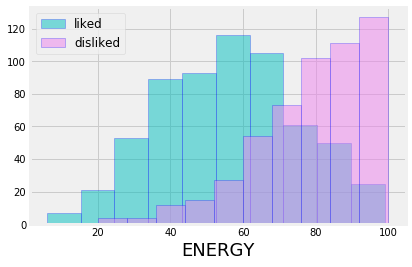

In [14]:
plt.hist(liked.ENERGY, label='liked',color="c", edgecolor="b", alpha=0.5)
plt.hist(disliked.ENERGY, label='disliked', color="violet", edgecolor="b", alpha=0.5)
plt.xlabel('ENERGY', fontsize=18)
plt.legend(fontsize=12)

We do exact same thing as above for BPM, DANCE, YEAR and DURATION using the **subplot()** function to properly display everything.

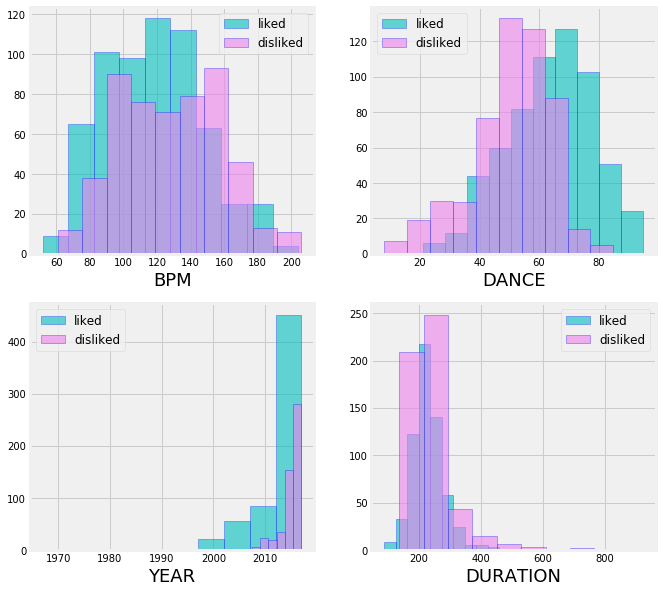

In [15]:
plt.subplots(2,2,figsize=(10,10))
plt.subplot(221)
plt.hist(liked["BPM"],label='liked',color="c", edgecolor="b", alpha=0.6)
plt.hist(disliked["BPM"], label='disliked', color="violet", edgecolor="b", alpha=0.6)
plt.xlabel('BPM', fontsize=18)
plt.legend(fontsize=12)

plt.subplot(222)
plt.hist(liked["DANCE"],label='liked',color="c", edgecolor="b", alpha=0.6)
plt.hist(disliked["DANCE"], label='disliked', color="violet", edgecolor="b", alpha=0.6)
plt.xlabel('DANCE', fontsize=18)
plt.legend(fontsize=12)

plt.subplot(223)
plt.hist(liked["YEAR"],label='liked',color="c", edgecolor="b", alpha=0.6)
plt.hist(disliked["YEAR"], label='disliked', color="violet", edgecolor="b", alpha=0.6)
plt.xlabel('YEAR', fontsize=18)
plt.legend(fontsize=12)

plt.subplot(224)
plt.hist(liked["DURATION"],label='liked',color="c", edgecolor="b", alpha=0.6)
plt.hist(disliked["DURATION"], label='disliked', color="violet", edgecolor="b", alpha=0.6)
plt.xlabel('DURATION', fontsize=18)
plt.legend(fontsize=12)

We want to check whether there are any outliers using a visualization to spot the outliers.

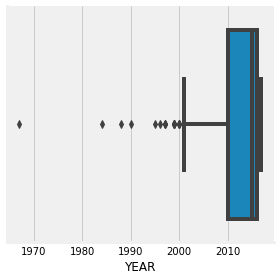

In [16]:
sns.factorplot(x='YEAR', data=liked, kind='box')
plt.show()

Let's remove that one song in liked dataset that was released before 1980.

In [17]:
liked=liked[liked['YEAR']>1980]

To make a model for predicting liked vs disliked songs we need to combine the two dataframes we have.

In [18]:
liked['TARGET'] = 1
disliked['TARGET'] = 0
combined = pd.concat([liked,disliked], ignore_index=True)
combined.head()

,TITLE,ARTIST,BPM,ENERGY,DANCE,LOUD,VALENCE,ACOUSTIC,POPULARITY,YEAR,DURATION,TARGET
0,Where Is My Mind?,Pixies,81.0,44.0,51.0,-14.0,24.0,1.0,35.0,2004,229,1
1,Give Me Nurture,rei brown,97.0,34.0,65.0,-5.0,7.0,88.0,33.0,2016,89,1
2,Lullaby,Atlas Bound,73.0,38.0,73.0,-9.0,17.0,38.0,56.0,2016,220,1
3,Warm On A Cold Night,HONNE,83.0,61.0,34.0,-6.0,39.0,19.0,63.0,2016,262,1
4,Release You,Tom Misch,120.0,36.0,54.0,-13.0,20.0,33.0,53.0,2014,233,1


Here we are just importing packages from **scicit-learn** library.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Let's find how many liked and disliked songs we have.

In [20]:
len_liked=liked.shape[0]
len_disliked=disliked.shape[0]

print("liked =",len_liked,"\ndisliked =",len_disliked)

liked = 619 
disliked = 529


We'll work with X and y (features and targets).

In [21]:
X=combined[["BPM","DANCE","ENERGY","LOUD","VALENCE","ACOUSTIC","POPULARITY"]]
y=combined.TARGET

Using train_test_split from sklearn, we divide our data into train and test.

In [22]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X,y,test_size=0.2,random_state=42)
print('Features Training Set:', X_train_im.shape, 'Features Testing Set:', X_test_im.shape)
print('Target Training Set:', y_train_im.shape, 'Target Testing Set:', y_test_im.shape)

Features Training Set: (918, 7) Features Testing Set: (230, 7)
Target Training Set: (918,) Target Testing Set: (230,)


We have more liked than disliked songs. Sometimes accuracy can increase if we rebalance the two classes.

In [23]:
df_minority = combined[combined.TARGET==0].sample(620, replace=True, random_state=12)

balanced = pd.concat([df_minority, combined[combined.TARGET==1]])

print(balanced.TARGET.value_counts())

0    620
1    619
Name: TARGET, dtype: int64


Again we want to separate X and y from each other, as well as divide data into train and test.

In [24]:
X_balanced = balanced[['BPM','ENERGY','DANCE','LOUD','VALENCE','ACOUSTIC','POPULARITY']]
y_balanced = balanced['TARGET']

In [25]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced)
print('Features Training Set:', X_train_bal.shape, 'Features Testing Set:', X_test_bal.shape)
print('Target Training Set:', y_train_bal.shape, 'Target Testing Set:', y_test_bal.shape)

Features Training Set: (929, 7) Features Testing Set: (310, 7)
Target Training Set: (929,) Target Testing Set: (310,)


Using KNeighborsClassifier() from sklearn we fit our X_train and y_train and evaluate our accuracy and save the result as **knn_accuracy**.

In [26]:
knn_accuracy=accuracy_score(y_test_im, KNeighborsClassifier().fit(X_train_im,y_train_im).predict(X_test_im))
knn_accuracy

0.7652173913043478

Now we do the same thing as above but using LogisticRegression instead of K Nearest Neighbors and save the accuracy score in **logreg_accuracy**.

In [27]:
logreg_accuracy=accuracy_score(y_test_im, LogisticRegression().fit(X_train_im,y_train_im).predict(X_test_im))
logreg_accuracy

0.782608695652174

Above we were working with unbalanced data, so below we repeat same thing for balanced data.

In [28]:
# KNN CLASSIFIER
knn = KNeighborsClassifier()
knn.fit(X_train_bal, y_train_bal)
y_pred_knn = knn.predict(X_test_bal)
knn_accuracy_bal = accuracy_score(y_test_bal, y_pred_knn)

# LOGISTIC REGRESSION 
logreg = LogisticRegression()
logreg.fit(X_train_bal, y_train_bal)
y_pred_logreg = logreg.predict(X_test_bal)
logreg_accuracy_bal = accuracy_score(y_test_bal, y_pred_logreg)


Here, we create a table summarizing the accuracy results.

In [29]:
accuracy = [('k-NN', '{:.2%}'.format(knn_accuracy), 
        '{:.2%}'.format(knn_accuracy_bal)),
         ('Logistic Regression', '{:.2%}'.format(logreg_accuracy), 
          '{:.2%}'.format(logreg_accuracy_bal))]

labels = ['Classifier', 'Imbalanced', 'Resampled']
df = pd.DataFrame.from_records(accuracy, columns=labels)
df

,Classifier,Imbalanced,Resampled
0,k-NN,76.52%,81.29%
1,Logistic Regression,78.26%,80.32%


# 2. Predicting Song Genre

In this project, we are exploring songs. We'll be trying to predict each song's genre from its lyrics. In particular, For each song, our dataset tells us the frequency with which each of these words occurs in the song. All words have been converted to lowercase.

All data we need is in `lyrics` table. **It may take up to a minute to load.**

In [30]:
lyrics = pd.read_csv('lyrics.csv')
lyrics.head()

,Title,Artist,Genre,i,the,you,to,and,a,me,...,writer,motivo,bake,insist,wel,santo,pe,gee,colleg,kad
0,Slicker Than Your Average,Craig David,Hip-hop,0.049536,0.017028,0.035604,0.020124,0.007740,0.006192,0.058824,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,Right There,MF Grimm,Hip-hop,0.037825,0.054374,0.023641,0.049645,0.009456,0.016548,0.018913,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,Talkin' All That,Cashis,Hip-hop,0.056738,0.049645,0.051418,0.010638,0.026596,0.033688,0.007092,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,It Only Hurts Me When I Cry,Raul Malo,Country,0.096491,0.074561,0.030702,0.017544,0.026316,0.017544,0.021930,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,Is It Too Late Now,Lester Flatt & Earl Scruggs,Country,0.043902,0.000000,0.073171,0.019512,0.000000,0.014634,0.034146,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


Let's find some song

In [31]:
lyrics[lyrics["Title"]=="In Your Eyes"]

,Title,Artist,Genre,i,the,you,to,and,a,me,...,writer,motivo,bake,insist,wel,santo,pe,gee,colleg,kad
1677,In Your Eyes,Alison Krauss,Country,0.107143,0.0,0.029762,0.0,0.035714,0.029762,0.035714,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


That cell prints a few columns of the row for the country song ["In Your Eyes" by Alison Krauss](http://www.azlyrics.com/lyrics/alisonkrauss/inyoureyes.html).  The song contains 168 words. The word "like" appears twice:  $\frac{2}{168} \approx 0.0119$ of the words in the song. The word "love" appears 10 times: $\frac{10}{168} \approx 0.0595$ of the words. The word "the" doesn't appear at all.

Our dataset doesn't contain all information about a song.  For example, it doesn't describe the order of words in the song, let alone the melody, instruments, or rhythm. Nonetheless, we may find that word frequencies alone are sufficient to build an accurate genre classifier.

All song titles are unique. The `row_title` function and `column_title` function provides fast access to the one row for each title. 

In [32]:
def row_title(title):
    return lyrics[lyrics["Title"]==title]

In [33]:
def column_title(title, column):
    return np.array(lyrics[lyrics["Title"]==title][column])[0]

For example, the fastest way to find the frequency of "love" in the song *Right THere* is to access the `'love'` column element with column_title function.

In [34]:
column_title("Right There", "love")

0.0

Using train_test_split function in sklearn we split the data into train and test.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(lyrics,lyrics["Genre"],test_size=0.2)
print("Training: ",   X_train.shape[0], ";",
      "Test: ",       X_test.shape[0])

Training:  1376 ; Test:  345


We write a function to compute the Euclidean distance between two **arrays** of features of *arbitrary* (but equal) length.

In [36]:
def distance(features1, features2):
    """The Euclidean distance between two arrays of feature values."""
    return np.sum((features1-features2)**2)**0.5

We choose 20 words that we think might let us distinguish between hiphop and country songs.

In [37]:
my_20_features = ["yesterday","today","peace","hey","help","mind","ya","face","!","i don't","wanna","someday","a","la"]

train_20 = X_train.loc[:, X_train.columns.isin(my_20_features)]
test_20 = X_test.loc[:, X_test.columns.isin(my_20_features)]

Using our train_20 and cross validation, we fit a model using KNeighborsClassifier().

In [38]:
knn = KNeighborsClassifier()
knn.fit(train_20, y_train)
y_pred_knn = knn.predict(test_20)
knn_accuracy_bal = accuracy_score(y_test, y_pred_knn)
knn_accuracy_bal

0.6811594202898551

Using our train_20 and cross validation, we fit a model using LogisticRegression().

In [39]:
logreg = LogisticRegression()
logreg.fit(train_20, y_train)
y_pred_logreg = logreg.predict(test_20)
logreg_bal = accuracy_score(y_test, y_pred_logreg)
logreg_bal

0.5130434782608696